In [1]:
% matplotlib inline
import os

import numpy as np
import pandas as pd  
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops

import pandas_ta as ta
import utils 

tf.reset_default_graph()
logs_path = os.path.join('log_tf')
visualize_group_timeseries = True
plot_row = 5        #How many rows do you want to plot in the visualization

In [2]:
"""Hyperparameters"""
num_filt_1 = 16     #Number of filters in first conv layer
num_filt_2 = 14      #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 128     #Number of neurons in hully connected layer
max_iterations = 2000
model_num=7         #Number of model used for voting
voting_times=3      #Threshold of voting
batch_size = 64
dropout = 0 # 1.0       #Dropout rate in the fully connected layer
regularization = 1e-4
learning_rate = 2e-6
input_norm = False   # Do you want z-score input normalization?
# np.set_printoptions(threshold=np.inf)#print full array

In [3]:
group_by_percent = [0,5,10,25]

In [4]:
datadir = os.path.join('Data','daily_sp500_1998-2013')
dataset = os.path.join(datadir, 'table_aapl.csv')
data = pd.read_csv(dataset,header=None,names=['Date','Time','Open','High','Low','Close','Volume'],parse_dates=['Date'])  
#data = data.sort_values(by='Date')  
data.set_index('Date',inplace=True)  

# add indicator
data = ta.EMA(data, 5, column='Close')
data = ta.EMA(data, 30, column='Close')

# label helper
data = utils.diff_next_n_bar(data, 20, column='Close', cat_diff=True, cat_diff_group_by_percent=group_by_percent)

data.head()

,Time,Open,High,Low,Close,Volume,EMA_5,EMA_30,DIFF_NEXT_20
Date,,,,,,,,,
1998-01-02,0,3.31397,3.95098,3.28236,3.95098,24947201.10,NaN,NaN,2
1998-01-05,0,4.01177,4.02635,3.69325,3.89020,22344145.08,NaN,NaN,3
1998-01-06,0,3.87561,4.98432,3.58628,4.60502,63150252.55,NaN,NaN,0
1998-01-07,0,4.57341,4.68040,4.20871,4.24032,36978255.52,4.241065,NaN,2
1998-01-08,0,4.24032,4.52965,4.11875,4.39107,27687622.95,4.298650,NaN,1


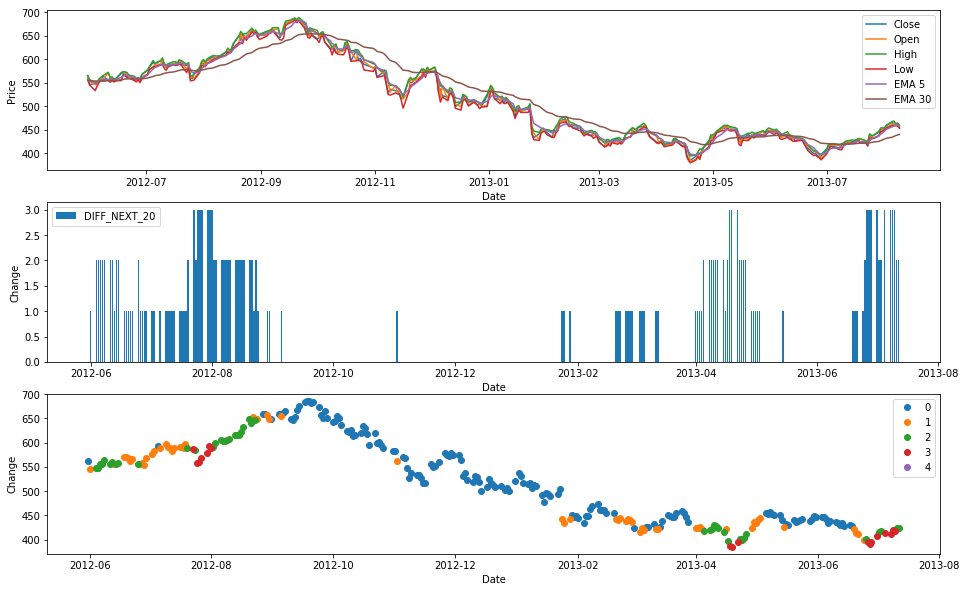

In [5]:
# Check Data
sub_data = data.iloc[-300:]

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(3,1,1)
ax.plot(sub_data.index, sub_data['Close'], label='Close')
ax.plot(sub_data.index, sub_data['Open'], label='Open')
ax.plot(sub_data.index, sub_data['High'], label='High')
ax.plot(sub_data.index, sub_data['Low'], label='Low')
ax.plot(sub_data.index, sub_data['EMA_5'], label='EMA 5')
ax.plot(sub_data.index, sub_data['EMA_30'], label='EMA 30')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

ax = fig.add_subplot(3,1,2)
ax.bar(sub_data.index, sub_data['DIFF_NEXT_20'], label='DIFF_NEXT_20')
ax.set_xlabel('Date')
ax.set_ylabel('Change')
ax.legend()

check_field = 'DIFF_NEXT_20'
color = ['red','green']
grouped = sub_data.groupby(check_field)
ax = fig.add_subplot(3,1,3)
for key, group in grouped:
    ax.plot(group.index, group['Close'], label=key, linestyle='none', marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Change')
ax.legend()

plt.show()

In [6]:
# Splite train,test,val
label_field = 'DIFF_NEXT_20'
test_size = 400
data_train = data.iloc[100:-test_size]
data_test,data_val = np.split(data.iloc[-test_size:],2)

X_train = data_train.iloc[:,:-1]
X_test = data_test.iloc[:,:-1]
X_val = data_val.iloc[:,:-1]

N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train.loc[:, label_field]
y_val = data_val.loc[:, label_field]
y_test = data_test.loc[:, label_field]
print('We have %s observations with %s dimensions'%(N,D))

We have 3426 observations with 8 dimensions


In [7]:
num_classes = len(np.unique(y_train))
base = np.min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -= base
    y_test -= base
    y_val -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    variance = np.var(X_train,axis=0)
    X_train -= mean
    #The 1e-9 avoids dividing by zero
    X_train /= np.sqrt(variance)+1e-9
    X_val -= mean
    X_val /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9
    
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))    

Train with approximately 37 epochs


Group : 0


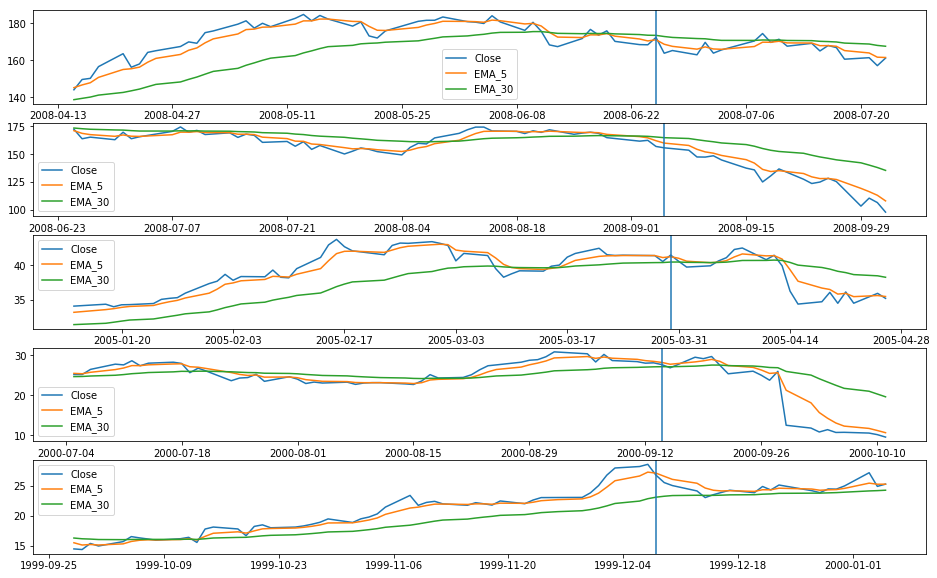

Group : 1


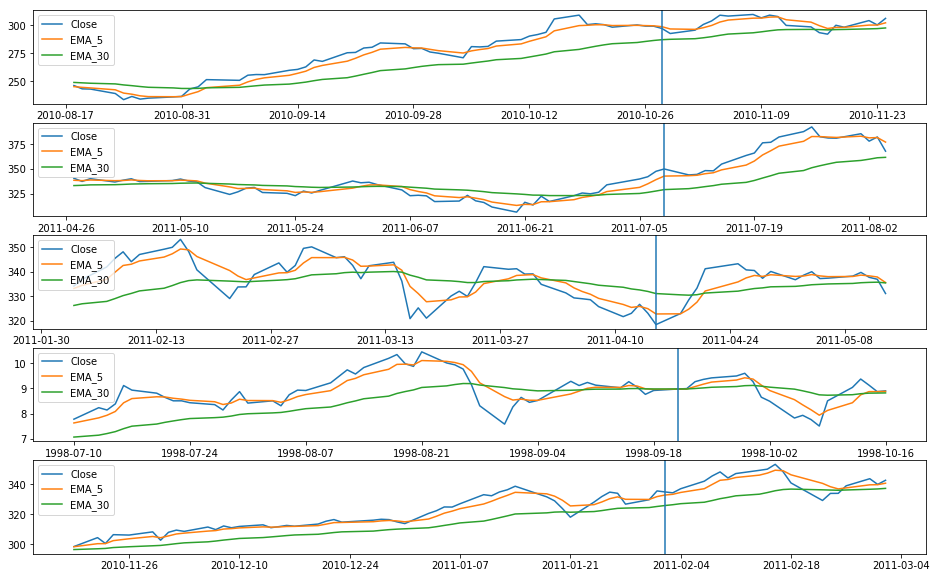

Group : 2


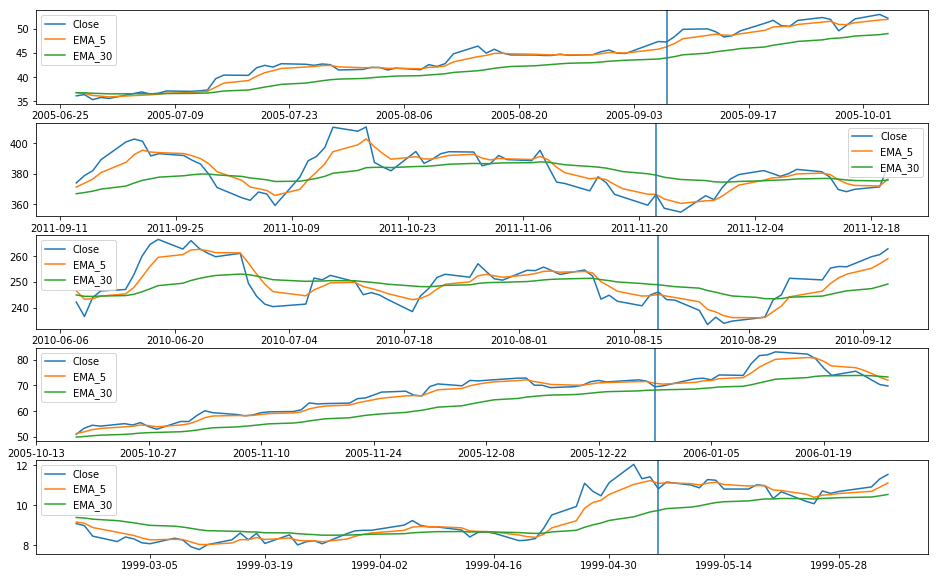

Group : 3


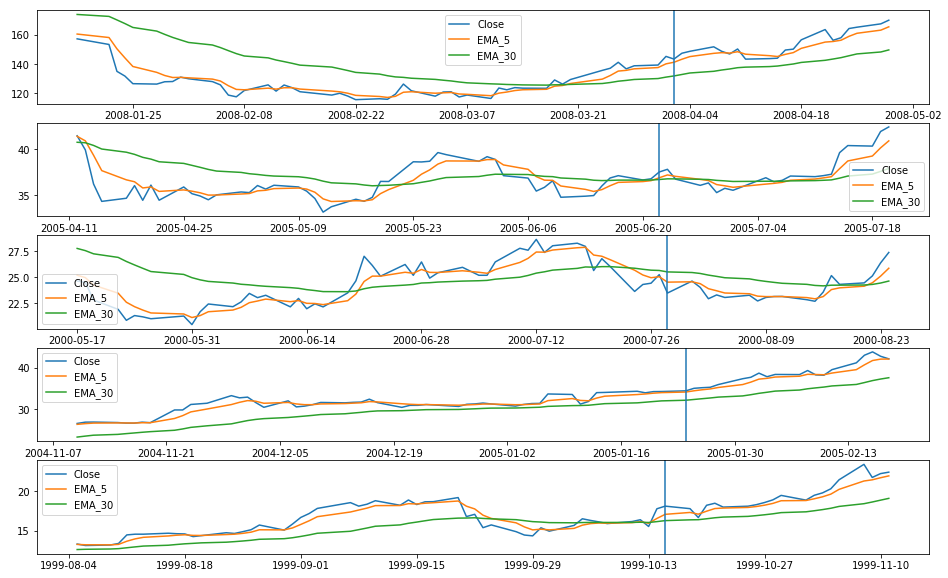

Group : 4


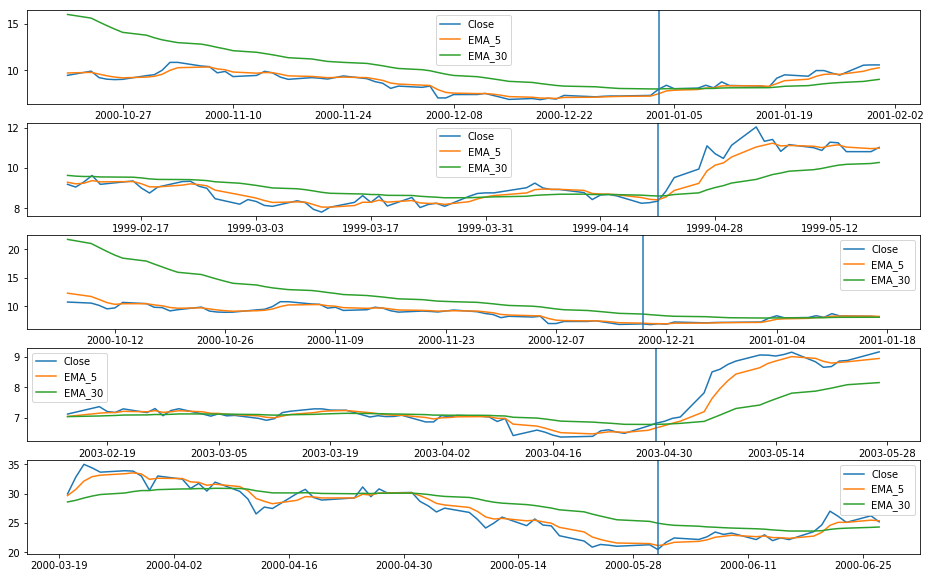

In [8]:
if visualize_group_timeseries:  #Set true if you want to visualize the actual time-series    
    for c in np.unique(y_train):    #Loops over classes, plot as columns
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0][5:-5],size=plot_row)
        print("Group : " + str(c))
        f, axarr = plt.subplots(plot_row, 1, figsize=(16,10))
        
        for n in range(plot_row):  #Loops over rows
            c = int(c)
            
            data_part = X_train.iloc[ind_plot[n]-50:ind_plot[n]+20]
            axarr[n].plot(data_part.index, data_part.loc[:,'Close'],label="Close")
            axarr[n].plot(data_part.index, data_part.loc[:,'EMA_5'],label="EMA_5")
            axarr[n].plot(data_part.index, data_part.loc[:,'EMA_30'],label="EMA_30")
            axarr[n].legend()
            axarr[n].axvline(x=data_part.index[50], label="Action")
        plt.show()

In [9]:
# Define functions for initializing variables and standard layers
#For now, this seems superfluous, but in extending the code
#to many more layers, this will keep our code
#read-able

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1], padding='SAME')

In [10]:
total_rst=np.zeros((model_num,len(y_test)), dtype=np.float)

initializer = tf.contrib.layers.xavier_initializer()
xx = 0
# for xx in range(0,model_num):
print("Training at model "+str(xx))
with tf.variable_scope('model_'+str(xx)):

    x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
    y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
    keep_prob = tf.placeholder("float")
    bn_train = tf.placeholder(tf.bool)                    #Boolean value to guide batchnorm

    with tf.name_scope("Reshaping_data") as scope:
        x_image = tf.reshape(x, [-1,D,1,1])

    ## Build the graph
    # ewma is the decay for which we update the moving average of the 
    # mean and variance in the batch-norm layers
    with tf.name_scope("Conv1") as scope:
        # W_conv1 = weight_variable([4, 1, 1, num_filt_1], 'Conv_Layer_1')
        W_conv1 = tf.get_variable("Conv_Layer_1", shape=[5, 1, 1, num_filt_1],initializer=initializer)
        b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
        a_conv1 = conv2d(x_image, W_conv1) + b_conv1

    with tf.name_scope('Batch_norm_conv1') as scope:
        # ewma = tf.train.ExponentialMovingAverage(decay=0.99)                                    
        # bn_conv1 = ConvolutionalBatchNormalizer(num_filt_1, 0.001, ewma, True)                     
        # update_assignments = bn_conv1.get_assigner() 
        # a_conv1 = bn_conv1.normalize(a_conv1, train=bn_train) 
        a_conv1 = tf.contrib.layers.batch_norm(a_conv1,is_training=bn_train,updates_collections=None)
        h_conv1 = tf.nn.relu(a_conv1)

    with tf.name_scope("Conv2") as scope:
        # W_conv2 = weight_variable([4, 1, num_filt_1, num_filt_2], 'Conv_Layer_2')
        W_conv2 = tf.get_variable("Conv_Layer_2", shape=[4, 1, num_filt_1, num_filt_2],initializer=initializer)
        b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
        a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2        

    with tf.name_scope('Batch_norm_conv2') as scope:
        # bn_conv2 = ConvolutionalBatchNormalizer(num_filt_2, 0.001, ewma, True)                     
        # update_assignments = bn_conv2.get_assigner() 
        # a_conv2 = bn_conv2.normalize(a_conv2, train=bn_train)       
        a_conv2 = tf.contrib.layers.batch_norm(a_conv2,is_training=bn_train,updates_collections=None)
        h_conv2 = tf.nn.relu(a_conv2)            

    with tf.name_scope("Conv3") as scope:
        # W_conv3 = weight_variable([4, 1, num_filt_2, num_filt_3], 'Conv_Layer_3')
        W_conv3 = tf.get_variable("Conv_Layer_3", shape=[4, 1, num_filt_2, num_filt_3],initializer=initializer)
        b_conv3 = bias_variable([num_filt_3], 'bias_for_Conv_Layer_3')
        a_conv3 = conv2d(h_conv2, W_conv3) + b_conv3

    with tf.name_scope('Batch_norm_conv3') as scope:
        # bn_conv3 = ConvolutionalBatchNormalizer(num_filt_3, 0.001, ewma, True)                     
        # update_assignments = bn_conv3.get_assigner() 
        # a_conv3 = bn_conv3.normalize(a_conv3, train=bn_train) 
        a_conv3 = tf.contrib.layers.batch_norm(a_conv3,is_training=bn_train,updates_collections=None)
        h_conv3 = tf.nn.relu(a_conv3)  

    with tf.name_scope("Fully_Connected1") as scope:
        # W_fc1 = weight_variable([D*num_filt_3, num_fc_1], 'Fully_Connected_layer_1')
        # W_fc1 = tf.get_variable("Fully_Connected_layer_1", shape=[D*num_filt_2, num_fc_1],initializer=initializer)
        W_fc1 = tf.get_variable("Fully_Connected_layer_1", shape=[D*num_filt_3, num_fc_1],initializer=initializer)
        b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
        # h_conv3_flat = tf.reshape(h_conv3, [-1, D*num_filt_3])
        # h_conv3_flat = tf.reshape(h_conv2, [-1, D*num_filt_2])
        h_conv3_flat = tf.reshape(h_conv3, [-1, D*num_filt_3])
        h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1) 

    with tf.name_scope("Fully_Connected2") as scope:
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        # W_fc2 = tf.Variable(tf.truncated_normal([num_fc_1, num_classes], stddev=0.1),name = 'W_fc2')
        W_fc2 = tf.get_variable("W_fc2", shape=[num_fc_1, num_classes],initializer=initializer)
        b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
        h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2        

    with tf.name_scope("SoftMax") as scope:
        #    regularizers = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(b_conv1) +
        #                  tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(b_conv2) +
        #                  tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(b_conv3) +
        #                  tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
        #                  tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h_fc2,labels=y_)
        cost = tf.reduce_sum(loss) / batch_size
        #    cost += regularization*regularizers
        loss_summ = tf.summary.scalar("cross_entropy_loss", cost)

    ## define train optimizer##
    with tf.name_scope("train") as scope:
        tvars = tf.trainable_variables()
        #We clip the gradients to prevent explosion
        grads = tf.gradients(cost, tvars)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        gradients = list(zip(grads, tvars))
        train_step = optimizer.apply_gradients(gradients)
        # The following block plots for every trainable variable
        #  - Histogram of the entries of the Tensor
        #  - Histogram of the gradient over the Tensor
        #  - Histogram of the grradient-norm over the Tensor
        numel = tf.constant([[0]])
        for gradient, variable in gradients:
            if isinstance(gradient, ops.IndexedSlices):
                grad_values = gradient.values
            else:
                grad_values = gradient

            numel +=tf.reduce_sum(tf.size(variable))

            #h1 = tf.summary.histogram(variable.name.replace(':','_'), variable)
            #h2 = tf.summary.histogram(variable.name.replace(':','_') + "/gradients", grad_values)
            #h3 = tf.summary.histogram(variable.name.replace(':','_') + "/gradient_norm", clip_ops.global_norm([grad_values]))

    with tf.name_scope("Evaluating_accuracy") as scope:
            correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            accuracy_summary = tf.summary.scalar("accuracy", accuracy)

    # merge all summaries into a single "operation" which we can execute in a session 
    merged = tf.summary.merge_all()

    ## run session and evaluate performance##
    perf_collect = np.zeros((3,int(np.floor(max_iterations /100))))
    cost_ma = 0.0
    acc_ma = 0.0
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(logs_path, sess.graph)
        # sess.run(tf.global_variables_initializer())
        sess.run(tf.global_variables_initializer())

        step = 0            # Step is a counter for filling the numpy array perf_collect
        for i in range(max_iterations):#training process
            batch_ind = np.random.choice(N,batch_size,replace=False).tolist()

            if i==0:
                acc_test_before = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
            if i%1000 == 0:
                #Check training performance
                result = sess.run([cost,accuracy],feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
                # print(" Training accuracy at %s out of %s is %s" % (i,max_iterations, result))
                # step +=1
                perf_collect[1,step] = acc_train = result[1]
                cost_train = result[0]

                #Check validation performance
                result = sess.run([cost, accuracy, merged], feed_dict={ x: X_val, y_: y_val, keep_prob: 1.0, bn_train : False})
                perf_collect[1,step] = acc_val = result[1]
                cost_val = result[0]
                if i == 0: cost_ma = cost_train
                if i == 0: acc_ma = acc_train
                cost_ma = 0.8*cost_ma+0.2*cost_train
                acc_ma = 0.8*acc_ma + 0.2*acc_train

                #Write information to TensorBoard
                writer.add_summary(result[2], i)
                writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
                print("At %5.0f/%5.0f Cost: train%5.3f val%5.3f(%5.3f) Acc: train%5.3f val%5.3f(%5.3f) " % 
                      (i,max_iterations, cost_train,cost_val,cost_ma,acc_train,acc_val,acc_ma))
                step +=1
            sess.run(train_step,feed_dict={x:X_train.iloc[batch_ind], y_: y_train.iloc[batch_ind], keep_prob: dropout, bn_train : True})

        #training process done!
        predict=sess.run(tf.argmax(h_fc2,1), feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
        total_rst[xx]=predict

        result = sess.run([accuracy,numel], feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
        acc_test = result[0]
        print('The network has %s trainable parameters'%(result[1]))            


Training at model 0
At     0/ 2000 Cost: train47835672.000 val  nan(47835672.000) Acc: train0.251 val0.055(0.251) 
At  1000/ 2000 Cost: train  nan val  nan(  nan) Acc: train0.381 val0.605(0.277) 
The network has [[10465]] trainable parameters


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
The accuracy on the test data is 0.370, before training was 0.265


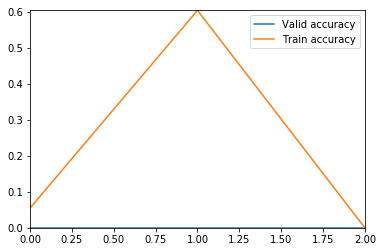

In [11]:
## show the graph of voting result
print(total_rst)

print('The accuracy on the test data is %.3f, before training was %.3f' %(acc_test,acc_test_before))
plt.figure()
plt.plot(perf_collect[0],label='Valid accuracy')
plt.plot(perf_collect[1],label = 'Train accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()